In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [27]:
transform = transforms.Compose( [
    transforms.ToTensor(),
    transforms.Normalize( 0.5, 0.5 )
] )

dataset = torchvision.datasets.MNIST( root = '../data', train = True, download = False, transform = transform )

dataloader = DataLoader( dataset, batch_size = 32, shuffle = True )

imgs, _ = next( iter ( dataloader ) )

imgs.shape

torch.Size([32, 1, 28, 28])

生成器

In [28]:
class Generator( nn.Module ):
    def __init__( self ):
        super( Generator, self ).__init__()
        self.method = nn.Sequential(
            nn.Linear( 100, 256 ),
            nn.ReLU(),
            nn.Linear( 256, 512 ),
            nn.ReLU(),
            nn.Linear( 512, 28 * 28 ),
            nn.Tanh()                               # (-1, 1)之间的数据分布，Tanh效果最好
        )
        
        
    def forward( self, x ):
        img = self.method( x )
        img = img.view( -1, 28, 28, 1 )
        return img

判别器
- 输入(1, 28, 28 )的图片，输出为二分类的概率

In [29]:
class Discriminator( nn.Module ):
    def __init__( self ):
        super( Discriminator, self ).__init__()
        self.method = nn.Sequential(
            nn.Linear( 28 * 28, 512 ),
            nn.LeakyReLU(),
            nn.Linear( 512, 256 ),
            nn.LeakyReLU(),
            nn.Linear( 256, 1 ),
            nn.Sigmoid()
        )
        
    def forward( self, x ):
        x = x.view( -1, 28 * 28 )                   # 展平
        x = self.method( x )
        return x 

In [30]:
def gen_img_plot( model, test_input ):                  # 绘图函数
    prediction = np.squeeze( model( test_input ).detach().cpu().numpy() ) 
    fig = plt.figure( figsize = ( 4, 4 ) )
    for i in range( 16 ):
        plt.subplot( 4, 4, i + 1 )
        plt.imshow( ( prediction[i] + 1) / 2 )          # 转换成0，1之间的数值
        plt.axis( 'off' )
    plt.show()


In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

test_input = torch.randn( 16, 100, device = device ) 

# 模型实例化、定义优化器和损失函数
gen = Generator().to( device )
dis = Discriminator().to( device )
d_optim = torch.optim.Adam( dis.parameters(), lr = 0.0001 )
g_optim = torch.optim.Adam( gen.parameters(), lr = 0.0001 )
loss_f = torch.nn.BCELoss()

训练

Epoch:  1 	D loss: 0.47889164090156555


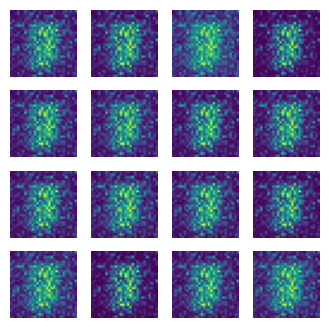

Epoch:  2 	D loss: 0.38435259461402893


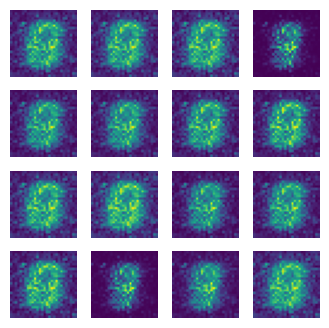

Epoch:  3 	D loss: 0.2514670193195343


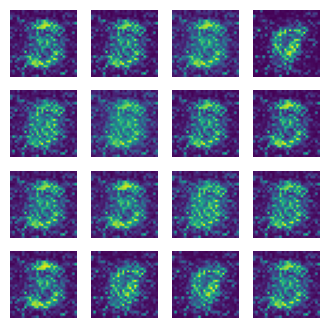

Epoch:  4 	D loss: 0.12984782457351685


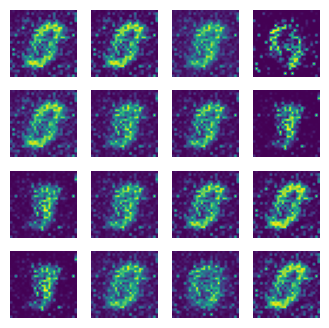

Epoch:  5 	D loss: 0.11165590584278107


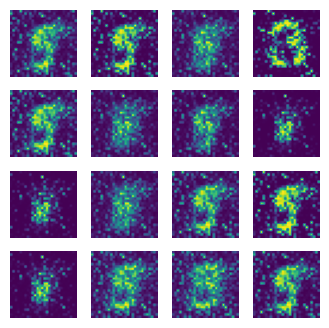

Epoch:  6 	D loss: 0.09455863386392593


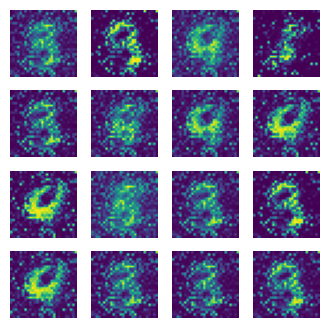

Epoch:  7 	D loss: 0.1328565776348114


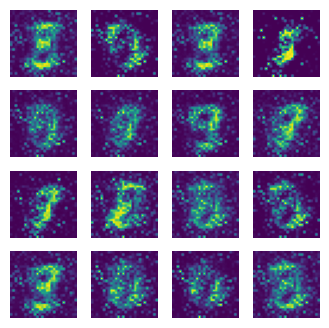

Epoch:  8 	D loss: 0.15952283143997192


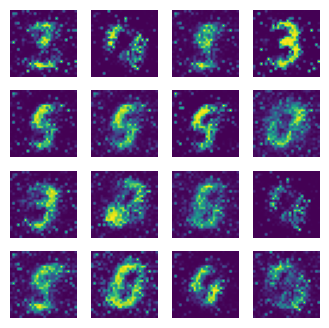

Epoch:  9 	D loss: 0.14741986989974976


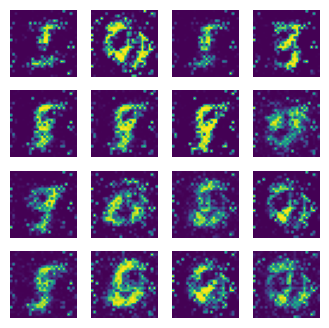

Epoch:  10 	D loss: 0.13077059388160706


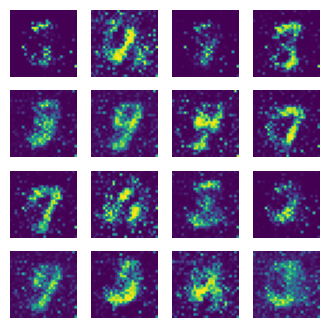

Epoch:  11 	D loss: 0.18318840861320496


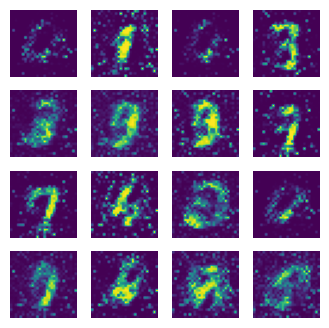

Epoch:  12 	D loss: 0.20349857211112976


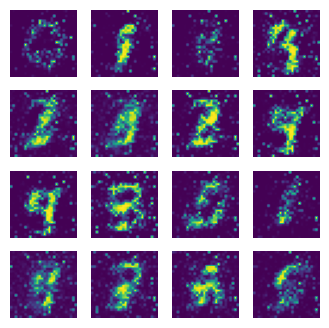

Epoch:  13 	D loss: 0.20430442690849304


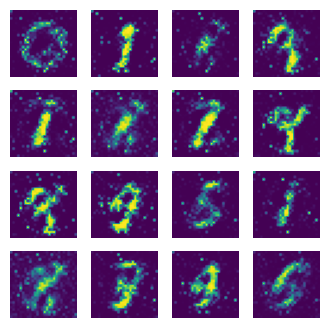

Epoch:  14 	D loss: 0.25584477186203003


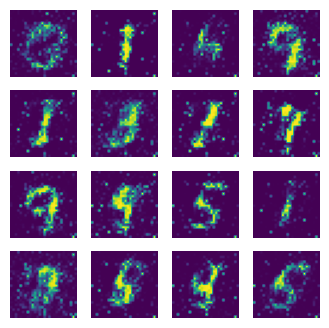

Epoch:  15 	D loss: 0.24795828759670258


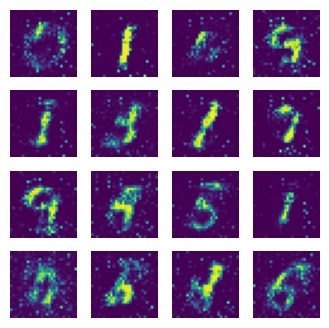

Epoch:  16 	D loss: 0.28870218992233276


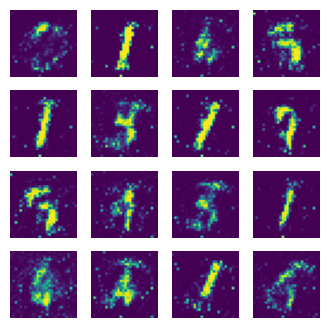

Epoch:  17 	D loss: 0.31850650906562805


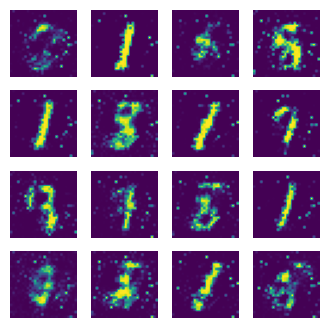

Epoch:  18 	D loss: 0.31738099455833435


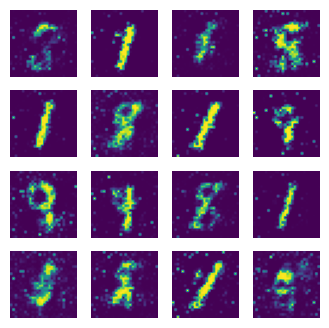

Epoch:  19 	D loss: 0.37467941641807556


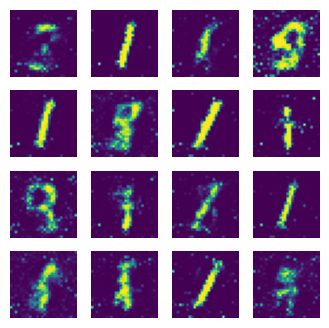

Epoch:  20 	D loss: 0.4463479816913605


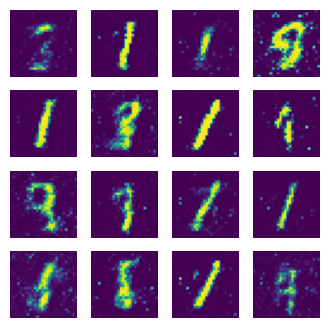

In [32]:
Gen_loss = []
Dis_loss = []
for epoch in range( 20 ):
    d_epoch_loss = 0
    g_epoch_loss = 0
    l = len( dataloader )
    for step, ( img, _ ) in enumerate( dataloader ):
        img = img.to( device )
        size = img.size( 0 )
        noise = torch.randn( size, 100, device = device )
        
        d_optim.zero_grad()
    
        real_output = dis( img )                                                    # 判别器输入真实图片的预测结果 -> 真1假0
        d_real_loss = loss_f( real_output, torch.ones_like( real_output ) )
        d_real_loss.backward()
        
        g_img = gen( noise )
        
        fake_output = dis( g_img.detach() )
        d_fake_loss = loss_f( fake_output, torch.zeros_like( fake_output ) )
        d_fake_loss.backward()
        
        d_loss = d_real_loss + d_fake_loss                                          # 总损失 -> 两部分
        d_optim.step()
        
        
        g_optim.zero_grad()
        fake_output = dis( g_img )
        g_loss = loss_f( fake_output, torch.ones_like( fake_output ) )              # 与1的差距 -> 生成器损失
        g_loss.backward()
        g_optim.step()
        
        with torch.no_grad():
            d_epoch_loss += d_loss
            g_epoch_loss += g_loss
            
    with torch.no_grad():
        d_epoch_loss /= l
        g_epoch_loss /= l
        Dis_loss.append( d_epoch_loss.item() )
        Gen_loss.append( g_epoch_loss.item() )
        print( 'Epoch: ', epoch + 1, '\tD loss:', d_epoch_loss.item() )
        gen_img_plot( gen, test_input )